# Alzheimer’s Disease Classification from Brain MRI (4-Class) — End-to-End CNN (TensorFlow/Keras)

This notebook is an **updated, presentation-ready** version of your previous training notebook, adapted for an **Alzheimer MRI 4-class classification** project.

## What you will do
1. Set up imports + reproducibility
2. Load and validate dataset folder structure
3. Preprocess MRI images (MRI-friendly)
4. Build a strong CNN using **transfer learning (DenseNet121)**
5. Train with callbacks + (optional) class weights
6. Evaluate with accuracy, classification report, and confusion matrix
7. Save the final model + run quick inference on a sample image

> **Note (medical disclaimer):** This is an educational ML project, **not** a medical diagnostic system.


# 🧠 Alzheimer MRI Classification using ResNet50

## 📌 Project Overview
This project implements a deep learning-based **Alzheimer MRI classification system** using transfer learning with **ResNet50**.

The model classifies MRI brain images into four categories:

- NonDemented  
- VeryMildDemented  
- MildDemented  
- ModerateDemented  

---

## 🏗️ Model Architecture

- Backbone: **ResNet50 (ImageNet Pretrained)**
- Input Size: **224 × 224 × 3**
- Fine-Tuning: Last **30 layers unfrozen**
- Output: Softmax (4 Classes)
- Training: **60 Epochs (Single Phase Training)**

---

## ⚙️ Training Pipeline

1. Data Loading & Preprocessing  
2. Data Augmentation  
3. Transfer Learning Setup  
4. Model Compilation  
5. Training for 60 epochs  
6. Model Evaluation  

---

## 📊 Evaluation Metrics

- Training Accuracy & Loss  
- Validation Accuracy & Loss  
- Confusion Matrix (Blue Heatmap)  
- Software-only Inference Latency (ms)  
- Software Throughput (FPS)  

---

## 🚀 Performance Measurement

The final section of this notebook measures:

- Average Latency (ms)  
- P95 Latency  
- Throughput (FPS)  
- Batch Throughput  

⚠️ All performance metrics represent **CPU-based software inference only**.

---

## 📦 Requirements

```bash
pip install tensorflow opencv-python numpy matplotlib
```

---

## 📁 Model Output

Final trained model:
```
alzheimer_resnet50_final.keras
```

This model can be:
- Used for CPU inference
- Converted to TensorFlow SavedModel
- Quantized & compiled for Vitis-AI DPU deployment

---

## 📌 Key Highlights

- Transfer Learning for Medical Imaging  
- Fine-tuned ResNet50  
- Structured Training Workflow  
- Deployment-ready architecture  
- Performance Benchmarking  

---


In [2]:
# =========================
# 1) Imports + Setup
# =========================
import os
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow:", tf.__version__)

TensorFlow: 2.10.1


## Reproducibility (recommended)
Deep learning is not perfectly deterministic on all hardware, but setting seeds makes results **more repeatable**.

In [3]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: makes some TF ops more deterministic (may reduce speed on GPU)
# tf.config.experimental.enable_op_determinism()

# 2) Dataset: Expected folder structure

Most Alzheimer MRI datasets are organized like:

```
dataset/
  train/
    NonDemented/
    VeryMildDemented/
    MildDemented/
    ModerateDemented/
  test/   (optional)
    ...
```

If your dataset only has a single folder (no train/test split), this notebook will create a **stratified split** for train/val/test automatically.

In [4]:
# =========================
# 2) Configure your dataset path here (FINAL WORKING CELL)
# =========================

import os
import zipfile

DATA_ROOT = "dataset"
ZIP_PATH = "Alzheimer_MRI_4_classes_dataset.zip"

os.makedirs(DATA_ROOT, exist_ok=True)

# Extract zip
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_ROOT)
    print("ZIP extracted successfully.")

# Dataset is inside nested folder
train_dir = os.path.join(DATA_ROOT, "Alzheimer_MRI_4_classes_dataset")
test_dir = None

# Detect real class folders
class_names = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])

print("Using train_dir:", train_dir)
print("Detected classes:", class_names)


ZIP extracted successfully.
Using train_dir: dataset\Alzheimer_MRI_4_classes_dataset
Detected classes: ['.ipynb_checkpoints', 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


## Detect classes
We infer classes from subfolder names inside the training folder.  
If no training folder exists, we will infer classes from `DATA_ROOT` directly (single-folder dataset).

In [5]:
def list_class_folders(root_dir: str):
    return sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
    ])

if train_dir is None:
    # Single-folder dataset fallback:
    # DATA_ROOT contains the class folders directly
    if os.path.isdir(DATA_ROOT) and len(list_class_folders(DATA_ROOT)) > 0:
        train_dir = DATA_ROOT
        print("Using single-folder dataset at:", train_dir)
    else:
        raise FileNotFoundError(
            "Could not find a training folder. Please set DATA_ROOT to your dataset directory."
        )

class_names = list_class_folders(train_dir)
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

assert NUM_CLASSES >= 2, "Need at least 2 class folders."

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CLASSES: 4


# 3) Build an index of all images
We scan the dataset folders and build a dataframe of:

- `filepath`
- `label` (class name)
- `label_id` (numeric)

This makes splitting and debugging easier.

In [6]:
IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def build_file_index(root_dir: str):
    rows = []
    classes = list_class_folders(root_dir)
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(IMAGE_EXTS):
                rows.append({"filepath": os.path.join(cls_dir, fname), "label": cls})
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError(f"No images found under: {root_dir}")
    df["label_id"] = df["label"].map({c:i for i,c in enumerate(classes)})
    return df, classes

df_all, classes_found = build_file_index(train_dir)
print(df_all.head())
print(df_all["label"].value_counts())

                                            filepath         label  label_id
0  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
1  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
2  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
3  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
4  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


# 4) Train/Validation/Test split (stratified)

- If you already have a separate `test/` folder, we use it as test set.
- Otherwise, we split from the same pool:
  - Train: 70%
  - Val:   15%
  - Test:  15%

Stratified splitting keeps class proportions similar across splits.

In [7]:
VAL_SIZE = 0.15
TEST_SIZE = 0.15  # used only when no external test_dir is found

if test_dir is not None:
    df_test, _ = build_file_index(test_dir)
    df_trainval = df_all.copy()

    df_train, df_val = train_test_split(
        df_trainval,
        test_size=VAL_SIZE,
        random_state=SEED,
        stratify=df_trainval["label_id"]
    )
else:
    df_train, df_temp = train_test_split(
        df_all,
        test_size=VAL_SIZE + TEST_SIZE,
        random_state=SEED,
        stratify=df_all["label_id"]
    )
    relative_val = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
    df_val, df_test = train_test_split(
        df_temp,
        test_size=1 - relative_val,
        random_state=SEED,
        stratify=df_temp["label_id"]
    )

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
print("Train label counts:\n", df_train["label"].value_counts())

Train: 4480 Val: 960 Test: 960
Train label counts:
 label
NonDemented         2240
VeryMildDemented    1568
MildDemented         627
ModerateDemented      45
Name: count, dtype: int64


# 5) MRI-friendly preprocessing

### Why we avoid aggressive contour-cropping here
Your earlier brain-tumor notebook used contour-based cropping (Otsu threshold).  
For Alzheimer staging, **subtle structure patterns** matter, and aggressive cropping can:

- cut out important regions
- behave inconsistently across slices

### We will do
- Read image with OpenCV
- Convert to grayscale (MRI is typically grayscale)
- Resize to model size (224×224)
- Normalize later using model-specific preprocessing

> If you still want cropping, use *center crop* (safe + consistent), not threshold-based crop.

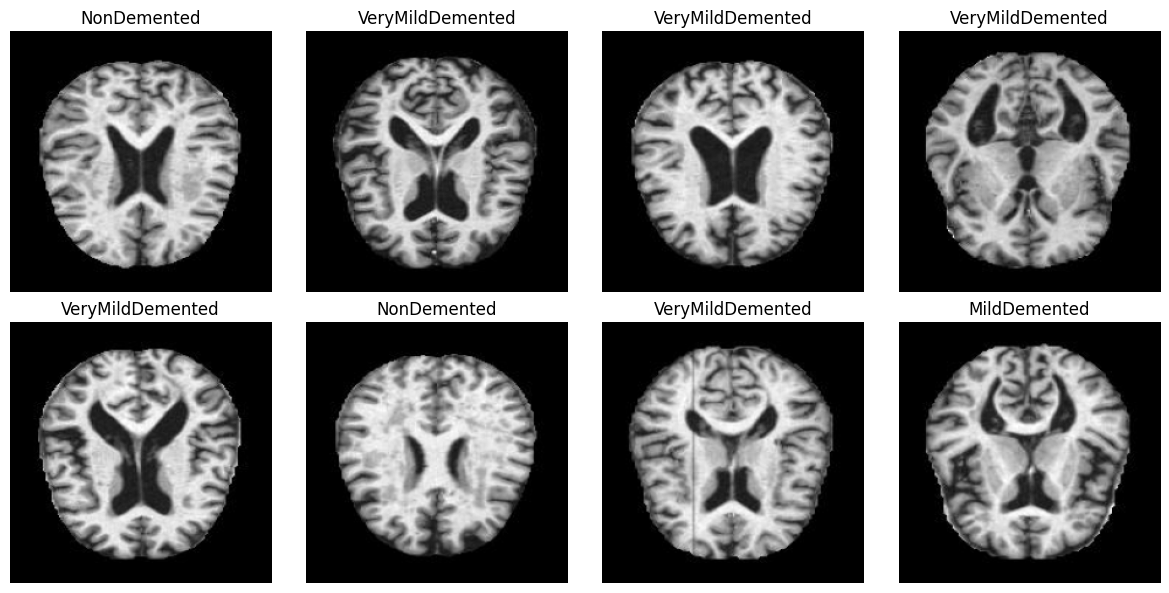

In [8]:
IMG_SIZE = (224, 224)

def read_mri_image(path: str, img_size=IMG_SIZE):
    # Read
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")

    # Resize
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

    # Convert to 3-channel (so ImageNet CNNs can be used)
    img = np.stack([img, img, img], axis=-1)  # (H, W, 3)
    return img

# Visualize a few samples
sample_paths = df_train.sample(n=min(8, len(df_train)), random_state=SEED)["filepath"].tolist()
plt.figure(figsize=(12, 6))
for i, p in enumerate(sample_paths):
    img = read_mri_image(p)
    plt.subplot(2, 4, i+1)
    plt.imshow(img[:, :, 0], cmap="gray")
    plt.title(os.path.basename(os.path.dirname(p)))
    plt.axis("off")
plt.tight_layout()
plt.show()

# 6) Create NumPy datasets (simple approach)

This approach loads images into memory (RAM).  
If your dataset is huge, switch to `tf.data` pipelines — but for most Kaggle Alzheimer datasets, this is fine.

We will create:
- `X_train, y_train`
- `X_val, y_val`
- `X_test, y_test`

In [9]:
def load_split(df: pd.DataFrame):
    X = np.zeros((len(df), IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    y = df["label_id"].values.astype(np.int32)
    for i, path in enumerate(df["filepath"].values):
        X[i] = read_mri_image(path)
    return X, y

X_train_raw, y_train = load_split(df_train.reset_index(drop=True))
X_val_raw,   y_val   = load_split(df_val.reset_index(drop=True))
X_test_raw,  y_test  = load_split(df_test.reset_index(drop=True))

print("X_train:", X_train_raw.shape, "y_train:", y_train.shape)
print("X_val  :", X_val_raw.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test_raw.shape,  "y_test :", y_test.shape)

X_train: (4480, 224, 224, 3) y_train: (4480,)
X_val  : (960, 224, 224, 3) y_val  : (960,)
X_test : (960, 224, 224, 3) y_test : (960,)


## One-hot encode labels
Keras softmax classifier expects one-hot labels for `categorical_crossentropy`.

In [10]:
y_train_oh = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_oh   = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_oh  = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

y_train_oh.shape, y_val_oh.shape, y_test_oh.shape

((4480, 4), (960, 4), (960, 4))

# 7) Data augmentation (MRI-safe)

We use **small** augmentations:
- slight rotation
- slight shift
- slight zoom

We avoid strong color transforms (MRI is grayscale), and we keep flips disabled by default.

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train_raw, y_train_oh, batch_size=32, shuffle=True, seed=SEED)
val_gen   = val_datagen.flow(X_val_raw, y_val_oh, batch_size=32, shuffle=False)

# 8) Model: Recommended CNN for this project (Edge / Vitis-friendly)

## Recommended: **ResNet50 (ImageNet pretrained)**
For deployment on **PYNQ + Vitis AI (.xmodel)**, ResNet50 is a strong choice:
- **Lightweight** (faster inference, smaller memory)
- **DPU-friendly** (quantization + compilation is usually smoother)
- Still provides good accuracy for 4-class classification

Training strategy:
1. **Freeze** the pretrained backbone and train the new classification head
2. **Fine-tune** the top layers with a smaller learning rate


In [12]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

NUM_CLASSES = len(class_names)  # should be 4

# Build backbone (ImageNet pretrained)
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

# ✅ Single-stage training setup (as requested):
# Unfreeze only the last 30 layers of the backbone, keep the rest frozen
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build full model
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = preprocess_input(inputs)              # ResNet50 preprocessing
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()


94765736/94765736 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                              

## Compile the model
We use:
- Adam optimizer
- categorical cross entropy
- accuracy metric

For imbalanced datasets, also compute **class weights** (optional but recommended).

In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Optional: class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 1.7862838915470494, 1: 24.88888888888889, 2: 0.5, 3: 0.7142857142857143}


# 9) Callbacks (training stability + best model saving)

- **EarlyStopping**: stop if validation stops improving
- **ReduceLROnPlateau**: lower LR when val loss plateaus
- **ModelCheckpoint**: always save the best model

In [14]:
CHECKPOINT_PATH = "best_alzheimer_ResNet50.keras"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(CHECKPOINT_PATH, monitor="val_loss", save_best_only=True)
]

# 10) Train (Phase 1): Train only the classification head

In [15]:
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=60,
    callbacks=callbacks,
    class_weight=class_weight_dict  # remove if you don't want class weighting
)

# Plot curves
plot_history(history1, 'ResNet50 (Last 30 layers unfrozen)')


Epoch 1/60
140/140 [==============================] - 66s 358ms/step - loss: 1.3794 - accuracy: 0.3594 - val_loss: 1.3050 - val_accuracy: 0.3562 - lr: 1.0000e-04
Epoch 2/60
140/140 [==============================] - 50s 359ms/step - loss: 1.0347 - accuracy: 0.4587 - val_loss: 1.3501 - val_accuracy: 0.3187 - lr: 1.0000e-04
Epoch 3/60
140/140 [==============================] - 47s 335ms/step - loss: 0.9572 - accuracy: 0.5074 - val_loss: 0.8767 - val_accuracy: 0.5719 - lr: 1.0000e-04
Epoch 4/60
140/140 [==============================] - 45s 323ms/step - loss: 0.7688 - accuracy: 0.5533 - val_loss: 0.7731 - val_accuracy: 0.6375 - lr: 1.0000e-04
Epoch 5/60
140/140 [==============================] - 46s 328ms/step - loss: 0.6711 - accuracy: 0.5837 - val_loss: 1.0537 - val_accuracy: 0.5219 - lr: 1.0000e-04
Epoch 6/60
140/140 [==============================] - 46s 330ms/step - loss: 0.6896 - accuracy: 0.5993 - val_loss: 0.7725 - val_accuracy: 0.6344 - lr: 1.0000e-04
Epoch 7/60
140/140 [========

NameError: name 'plot_history' is not defined

## Plot training curves

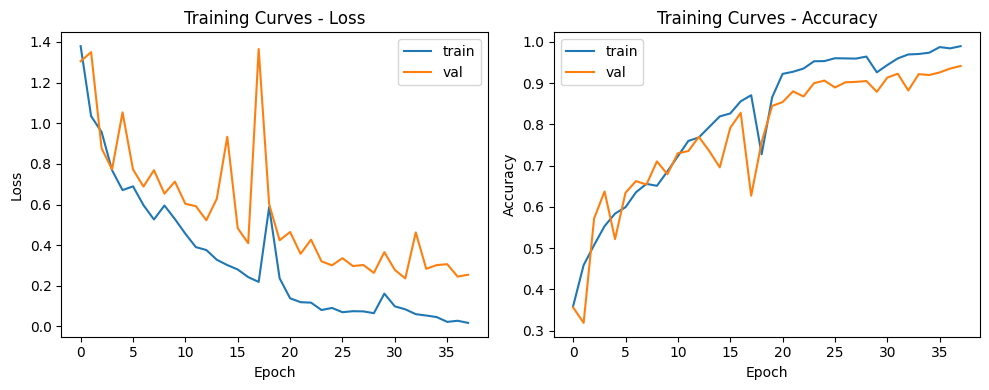

In [27]:
def plot_history(hist, title="Training Curves"):
    plt.figure(figsize=(10,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"], label="train")
    plt.plot(hist.history["val_accuracy"], label="val")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1)

# 11) Single-stage fine-tuning (ResNet50)

As requested, we **do not split training into phases**.

- The ResNet50 backbone is loaded with ImageNet weights.
- Only the **last 30 layers** of the backbone are unfrozen (trainable).
- The rest of the backbone remains frozen.
- We train for **60 epochs in a single `fit()` call** (with early stopping + LR scheduling).


# 12) Evaluation on the test set

We report:
- Test accuracy
- Classification report (precision/recall/F1 per class)
- Confusion matrix (visual)

Test Loss: 0.2292
Test Accuracy: 0.9115

Classification Report:
                  precision    recall  f1-score   support

     NonDemented     0.8897    0.9556    0.9214       135
VeryMildDemented     1.0000    1.0000    1.0000         9
    MildDemented     0.9744    0.8708    0.9197       480
ModerateDemented     0.8462    0.9494    0.8948       336

        accuracy                         0.9115       960
       macro avg     0.9275    0.9439    0.9340       960
    weighted avg     0.9178    0.9115    0.9120       960

Confusion Matrix:
 [[129   0   2   4]
 [  0   9   0   0]
 [  8   0 418  54]
 [  8   0   9 319]]


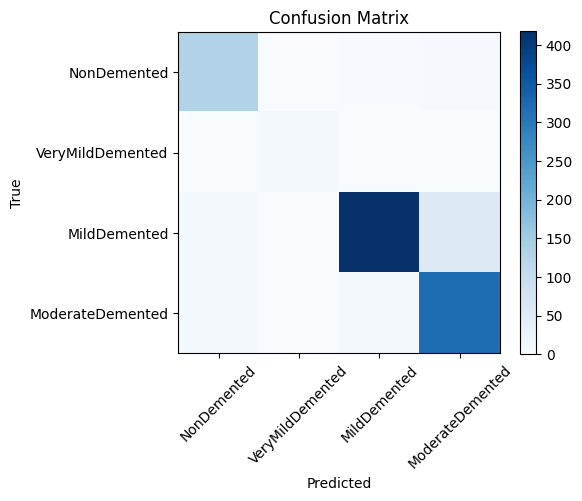

In [25]:
# Load best model (ensures we evaluate the best checkpoint)
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
num_classes = len(class_names)
test_loss, test_acc = best_model.evaluate(X_test_raw, y_test_oh, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_prob = best_model.predict(X_test_raw, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 13) Save final model + quick inference

We save:
- Best checkpoint (already saved by callback)
- An additional final export (optional)

Then we run inference on a single image.

In [18]:
FINAL_EXPORT_PATH = "alzheimer_ResNet50_final.keras"
best_model.save(FINAL_EXPORT_PATH)
print("Saved final model to:", FINAL_EXPORT_PATH)

Saved final model to: alzheimer_ResNet50_final.keras


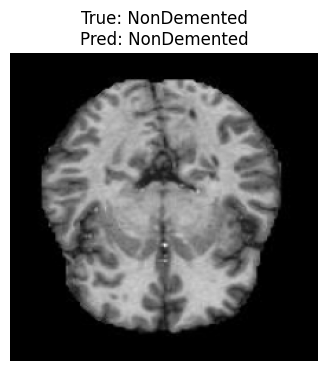

Predicted probabilities:
MildDemented        : 0.0000
ModerateDemented    : 0.0000
NonDemented         : 1.0000
VeryMildDemented    : 0.0000


In [23]:
# Quick inference on a single test image
idx = 0
img = X_test_raw[idx]
true_label = class_names[y_test[idx]]

pred_probs = best_model.predict(img[None, ...], verbose=0)[0]
pred_id = int(np.argmax(pred_probs))
pred_label = class_names[pred_id]

plt.figure(figsize=(4,4))
plt.imshow(img[:, :, 0], cmap="gray")
plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.axis("off")
plt.show()
;
print("Predicted probabilities:")
for c, p in zip(class_names, pred_probs):
    print(f"{c:20s}: {p:.4f}")

In [28]:
import os
import shutil
import tensorflow as tf

SAVEDMODEL_DIR = "saved_model_keras"

# Remove old folder if exists
if os.path.exists(SAVEDMODEL_DIR):
    shutil.rmtree(SAVEDMODEL_DIR)

# Export SavedModel (Vitis AI compatible)
tf.saved_model.save(best_model, SAVEDMODEL_DIR)

print("SavedModel exported to:", SAVEDMODEL_DIR)
print("Contents:", os.listdir(SAVEDMODEL_DIR))


INFO:tensorflow:Assets written to: saved_model_keras\assets


INFO:tensorflow:Assets written to: saved_model_keras\assets


SavedModel exported to: saved_model_keras
Contents: ['assets', 'saved_model.pb', 'variables']


In [29]:
import os, shutil, tensorflow as tf

# Load your trained model (use your actual filename)
m = tf.keras.models.load_model("alzheimer_ResNet50_final.keras")

EXPORT_DIR = "saved_model_keras_vitis"

# Remove old folder if exists
if os.path.exists(EXPORT_DIR):
    shutil.rmtree(EXPORT_DIR)

# IMPORTANT: this produces keras_metadata.pb
m.save(EXPORT_DIR, save_format="tf")

print("Exported to:", EXPORT_DIR)
print("Files:", os.listdir(EXPORT_DIR))


INFO:tensorflow:Assets written to: saved_model_keras_vitis\assets


INFO:tensorflow:Assets written to: saved_model_keras_vitis\assets


Exported to: saved_model_keras_vitis
Files: ['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


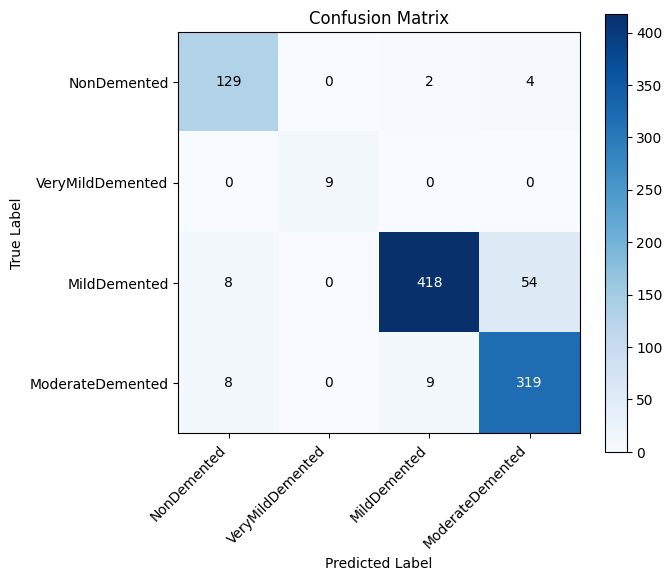

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Alzheimer class order (keep same everywhere)
class_names = ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented']

# cm must be a 4x4 numpy array
cm = np.array(cm)

plt.figure(figsize=(7,6))
im = plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar(im)

plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# ✅ write numbers inside cells
thresh = cm.max() / 2.0 if cm.max() != 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [1]:
import os
import time
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATH = "alzheimer_resnet50_final.keras"   # change if needed
IMG_SIZE = (224, 224)

# -----------------------------
# Load trained model (CPU only)
# -----------------------------
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
model.trainable = False
print("✅ Model loaded")

# -----------------------------
# Pick one sample image
# -----------------------------
# change this if needed
SAMPLE_IMAGE_PATH = None  

if SAMPLE_IMAGE_PATH is None:
    # try to auto-detect any image in dataset
    images = []
    for ext in ["*.jpg","*.jpeg","*.png"]:
        images += glob.glob(os.path.join("**", ext), recursive=True)
    SAMPLE_IMAGE_PATH = images[0]

print("Using image:", SAMPLE_IMAGE_PATH)

def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    x = np.expand_dims(img.astype(np.float32), axis=0)
    x = preprocess_input(x)
    return x

x = preprocess_image(SAMPLE_IMAGE_PATH)

✅ Model loaded
Using image: dataset\Alzheimer_MRI_4_classes_dataset\MildDemented\1 (10).jpg


In [2]:
import time
import numpy as np

# Warmup
for _ in range(10):
    _ = model(x, training=False).numpy()

# -----------------------------
# Measure Latency
# -----------------------------
N = 100
times = []

for _ in range(N):
    start = time.perf_counter()
    _ = model(x, training=False).numpy()
    end = time.perf_counter()
    times.append((end - start) * 1000)

print("========== CPU PERFORMANCE ==========")
print("Average Latency  : {:.2f} ms".format(np.mean(times)))
print("P95 Latency      : {:.2f} ms".format(np.percentile(times, 95)))
print("Min Latency      : {:.2f} ms".format(np.min(times)))
print("Max Latency      : {:.2f} ms".format(np.max(times)))

# -----------------------------
# Throughput
# -----------------------------
M = 200
start = time.perf_counter()
for _ in range(M):
    _ = model(x, training=False).numpy()
end = time.perf_counter()

fps = M / (end - start)

print("Throughput (FPS) : {:.2f}".format(fps))
print("======================================")

========== CPU PERFORMANCE ==========
Average Latency  : 101.04 ms
P95 Latency      : 141.48 ms
Min Latency      : 75.30 ms
Max Latency      : 157.52 ms
Throughput (FPS) : 10.18


In [ ]:
k